<a href="https://colab.research.google.com/github/Jefferson-Luis/SoulCode_Embraer/blob/main/projetob2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


```
Vendas B2B - O objetivo deste projeto é desenvolver um dashboard simples que permita analisar informações básicas sobre vendas B2B.
    * O projeto deverá contemplar os seguintes pontos de análise:
    * Volume total de vendas por região.
    * Receita total por setor.
    * Quantidade de vendas por categoria de produto.
    * Desempenho individual dos vendedores (valor total vendido).
    * Produtos mais vendidos.

```

A imagem abaixo mostra como diferentes tabelas de um banco de dados se relacionam para registrar vendas.

1.   Clientes: Guarda informações sobre cada cliente (ID, nome, setor, tamanho da empresa, região).
2.   Produtos: Guarda informações sobre cada produto (ID, nome, preço, categoria).
3. Vendedores: Guarda informações sobre cada vendedor (ID, nome, região).
4. Vendas: Guarda informações sobre cada venda, criando um elo entre as outras tabelas. Cada venda se refere a um único cliente, um único vendedor, e um único produto.

Relacionamentos:

* Um cliente pode fazer várias vendas (um para muitos).

* Um produto pode ser vendido em várias vendas (um para muitos).

* Um vendedor pode fazer várias vendas (um para muitos).

Em resumo, a tabela "Vendas" conecta as informações de Clientes, Produtos e Vendedores para rastrear cada venda individualmente. A redundância entre ID_Vendedor/idVendedores (e similares) é problemática; um campo por tipo de dado é suficiente para manter uma boa forma, e é considerado uma boa prática quando criando bancos de dados.

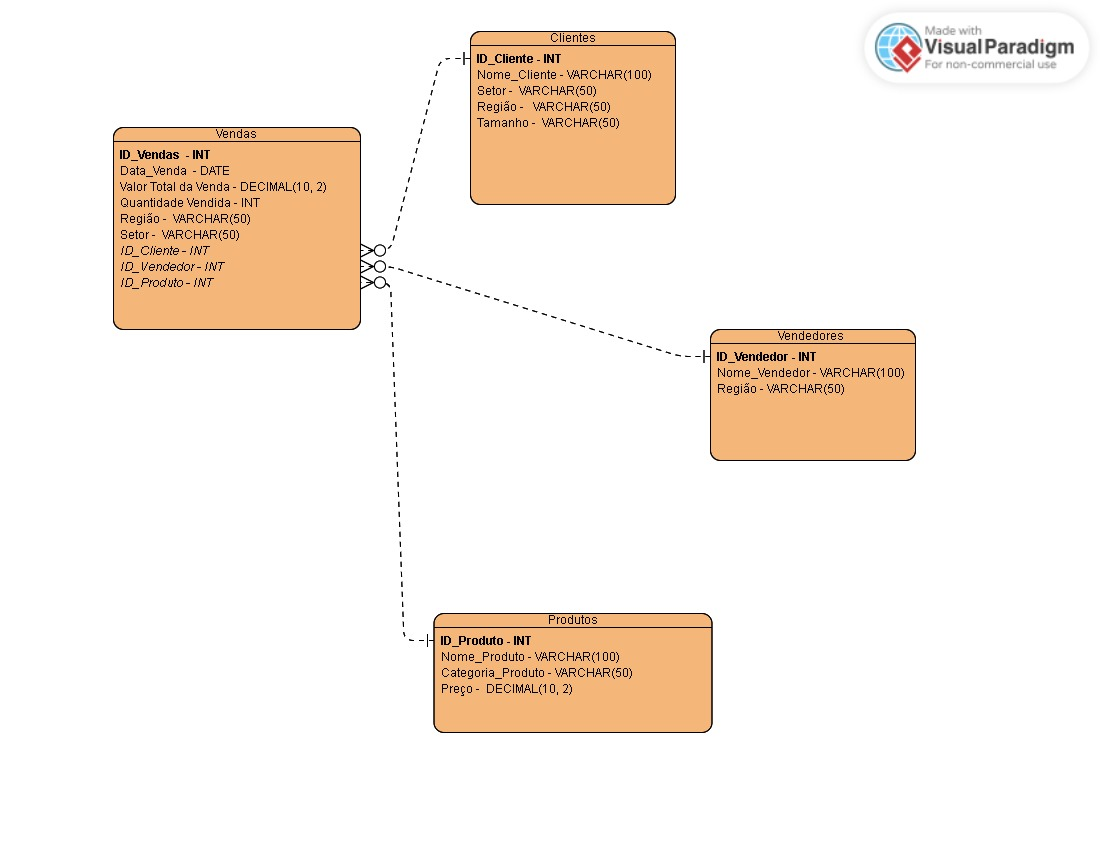

* Este projeto aborda o desafio de processar dados de vendas distribuídos em múltiplos arquivos no Google Cloud Storage. Para superar os problemas de inconsistências nos dados (codificação, tipos, valores ausentes), foi desenvolvido um pipeline ETL completo. O código utiliza o Pandas para manipulação e limpeza, com funções dedicadas ao tratamento de dados, juntando os conjuntos de dados numa unica tabela limpa, eficiente e concisa.

* Este script tem como objetivo realizar o processamento e a transformação de dados a partir de arquivos CSV armazenados no Google Cloud Storage (GCS) e carregá-los no Google BigQuery. O processo inclui as etapas de extração de dados, limpeza, transformação (tratamento de valores nulos e conversão de tipos de dados), e carregamento de dados tanto no GCS quanto no BigQuery

1. Instalação das Bibliotecas

In [ ]:
import pandas as pd
from google.cloud import storage, bigquery
from google.colab import auth
from google.api_core.exceptions import NotFound

2. O script começa com a autenticação do usuário no Google Cloud utilizando o auth.authenticate_user(), permitindo o acesso aos serviços de Google Cloud Storage (GCS) e BigQuery..



In [ ]:
auth.authenticate_user()

3. Configuração de Parâmetros de Projeto e Armazenamento:

* O ID do projeto (project_id), o nome do bucket no GCS (bucket_name) e o dataset no BigQuery (dataset_bigquery) são configurados. Esses parâmetros são essenciais para localizar e carregar os dados para os respectivos destinos.

In [ ]:
project_id = "embraer-etl-gcp"
bucket_name = "embraer_soulcode_projeto"
dataset_bigquery = "soulcode_dataset"

4. Definição dos Arquivos CSV no GCS
* arquivos_csv: Dicionário que mapeia os nomes das tabelas para os caminhos dos arquivos CSV no Google Cloud Storage.

In [ ]:
arquivos_csv = {
    "clientes": "grupo3_dados_brutos_embraer_soulcode/Cópia de Cópia de Base_Dados_Vendas_B2B(Clientes).csv",
    "produtos": "grupo3_dados_brutos_embraer_soulcode/Cópia de Cópia de Base_Dados_Vendas_B2B(Produtos).csv",
    "vendas": "grupo3_dados_brutos_embraer_soulcode/Cópia de Cópia de Base_Dados_Vendas_B2B(Vendas).csv",
    "vendedores": "grupo3_dados_brutos_embraer_soulcode/Cópia de Cópia de Base_Dados_Vendas_B2B(Vendedores).csv"
}



5. Função extrair_dados_gcs:

* Esta função extrai os dados de arquivos CSV armazenados no GCS. Ela tenta ler os arquivos em diferentes encodings (latin-1 e utf-8) para garantir que os dados sejam carregados corretamente, mesmo em caso de problemas de codificação.
Ela utiliza a biblioteca pandas para carregar os dados em DataFrames, que são então processados para as etapas subsequentes

In [ ]:
def extrair_dados_gcs(bucket_name, blob_name):
    try:
        storage_client = storage.Client(project=project_id)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        with blob.open("rb") as f:
            try:
                df = pd.read_csv(f, encoding='latin-1', sep=';', on_bad_lines='skip')
            except UnicodeDecodeError:
                print(f"Erro de codificação em '{blob_name}'. Tentando UTF-8...")
                df = pd.read_csv(f, encoding='utf-8', sep=';', on_bad_lines='skip')
            return df
    except Exception as e:
        print(f"Erro ao acessar ou processar o blob '{blob_name}': {e}")
        return pd.DataFrame()


6. Função limpar_dados:

* A função limpar_dados faz a limpeza dos dados extraídos, preenchendo valores ausentes (nulos):
Para colunas numéricas, os valores ausentes são preenchidos com a média da coluna.
* Para colunas de texto, os valores ausentes são preenchidos com a string 'Desconhecido'.
* Também são removidos os registros duplicados e aplicadas transformações em colunas do tipo texto para garantir que os valores sejam consistentes (remoção de espaços e padronização da capitalização

In [ ]:
def limpar_dados(df):
    df = df.copy()
    for col in df.columns:
        if df[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].mean())
            else:
                df[col] = df[col].fillna('Desconhecido')

    # Remover as linhas onde "Desconhecido" aparece em qualquer coluna
    df = df[~df.isin(['Desconhecido']).any(axis=1)]

    df.drop_duplicates(inplace=True)
    for col in df.select_dtypes(include=['object']):
        df[col] = df[col].str.strip().str.title()
    return df


7. Função corrigir_e_filtrar:

* Esta função aplica correções adicionais para garantir que os dados estejam no formato correto antes do carregamento no BigQuery:
* Conversão de Tipos: Converte valores numéricos armazenados como strings (e.g., ID_Cliente, ID_Produto, ID_Vendedor, etc.) para inteiros.
* Conversão de Data: A coluna Data_Venda é convertida para o tipo datetime, utilizando o formato '%Y-%m-%d', para garantir que os dados sejam tratados corretamente no BigQuery.


In [ ]:
def corrigir_e_filtrar(dfs):

    # Adjusting for float64 columns like ID_Cliente, ID_Produto
    for nome, df in dfs.items():
        if 'ID_Cliente' in df.columns:
            df['ID_Cliente'] = df['ID_Cliente'].fillna(0).astype('int')
        if 'ID_Produto' in df.columns:
            df['ID_Produto'] = df['ID_Produto'].fillna(0).astype('int')
        if 'ID_Vendedor' in df.columns:
            df['ID_Vendedor'] = df['ID_Vendedor'].fillna(0).astype('int')

        # Convertendo a coluna Data_Venda para datetime
        if 'Data_Venda' in df.columns:
            df['Data_Venda'] = pd.to_datetime(df['Data_Venda'], format='%Y-%m-%d', errors='coerce')

    return dfs


8. Função criar_dataset_bigquery:

* Antes de carregar os dados no BigQuery, o script verifica se o dataset no BigQuery já existe. Se não existir, o script cria o dataset. Isso garante que o BigQuery tenha o local adequado para armazenar as tabelas.

In [ ]:
# Função para criar conjunto de dados no BigQuery
def criar_dataset_bigquery(dataset_id):
    bigquery_client = bigquery.Client(project=project_id)
    try:
        dataset = bigquery_client.get_dataset(dataset_id)
        print(f"Dataset {dataset_id} já existe.")
    except NotFound:
        dataset = bigquery_client.create_dataset(dataset_id)
        print(f"Dataset {dataset_id} criado com sucesso.")


09. Função para Carregar Dados no BigQuery
* Execução ETL:
* Para cada arquivo CSV, os dados são extraídos do GCS, limpos e transformados.
* Os IDs são convertidos para inteiros.
* O dataset no BigQuery é criado (se necessário).
Finalmente, os dados limpos e transformados são carregados nas tabelas do BigQuery.

In [ ]:
def carregar_bigquery(dfs, dataset_id):
    try:
        bigquery_client = bigquery.Client(project=project_id)
        for nome, df in dfs.items():
            if not df.empty:
                tabela_id = f"{dataset_id}.{nome}"
                job_config = bigquery.LoadJobConfig(
                    write_disposition="WRITE_TRUNCATE",
                    source_format=bigquery.SourceFormat.CSV
                )
                job = bigquery_client.load_table_from_dataframe(
                    df, tabela_id, job_config=job_config
                )
                job.result()
                print(f"Dados carregados com sucesso no BigQuery: {tabela_id}")
    except Exception as e:
        print(f"Erro ao carregar dados no BigQuery: {e}")


10. Função carregar_gcs:

* Após o processamento e limpeza dos dados, a função carregar_gcs faz o upload dos DataFrames para o GCS, convertendo-os de volta para o formato CSV. Os arquivos são armazenados em um diretório chamado dados_tratados/ no GCS.

In [ ]:
def carregar_gcs(dfs, bucket_name):
    storage_client = storage.Client(project=project_id)
    for nome, df in dfs.items():
        if not df.empty:
            caminho_gcs = f"dados_tratados/{nome}.csv"
            bucket = storage_client.bucket(bucket_name)
            blob = bucket.blob(caminho_gcs)
            blob.upload_from_string(df.to_csv(index=False), content_type='text/csv')
            print(f"Dados carregados com sucesso no GCS: {caminho_gcs}")


11. Essa função realiza uma sequência de operações para extrair, limpar, filtrar e carregar dados em dois destinos: o Google Cloud Storage (GCS) e o BigQuery.

  1. Extrair dados do GCS: Carregar arquivos CSV armazenados no GCS.
  2. Limpar dados: Tratar dados ausentes, corrigir formatação e remover duplicatas.
  3. Corrigir e filtrar dados: Ajustar tipos de dados e garantir a consistência para análise.
  4. Criar dataset no BigQuery: Criar um conjunto de dados (dataset) no BigQuery.
  5. Carregar dados no GCS: Carregar os dados tratados de volta para o GCS.
  6. Carregar dados no BigQuery: Transferir os dados tratados para tabelas no BigQuery para análise e relatórios.

In [ ]:
# Extrair, limpar, filtrar e carregar dados
dfs = {}
for nome, caminho in arquivos_csv.items():
    dfs[nome] = extrair_dados_gcs(bucket_name, caminho)
    if not dfs[nome].empty:
        dfs[nome] = limpar_dados(dfs[nome])

dfs = corrigir_e_filtrar(dfs)

# Create dataset in BigQuery
dataset_id = "dados_tratados"
criar_dataset_bigquery(dataset_id)

# Load data into GCS and BigQuery
carregar_gcs(dfs, bucket_name)
carregar_bigquery(dfs, dataset_id)

Dataset dados_tratados já existe.
Dados carregados com sucesso no GCS: dados_tratados/clientes.csv
Dados carregados com sucesso no GCS: dados_tratados/produtos.csv
Dados carregados com sucesso no GCS: dados_tratados/vendas.csv
Dados carregados com sucesso no GCS: dados_tratados/vendedores.csv
Dados carregados com sucesso no BigQuery: dados_tratados.clientes
Dados carregados com sucesso no BigQuery: dados_tratados.produtos
Dados carregados com sucesso no BigQuery: dados_tratados.vendas
Dados carregados com sucesso no BigQuery: dados_tratados.vendedores


In [ ]:
# data frame carregados

print(dfs['clientes'])
print(dfs['produtos'])
print(dfs['vendas'])
print(dfs['vendedores'])

     ID_Cliente                  Nome_Cliente       Setor        Região  \
0             1        Haley, Arnold And Bush  Manufatura         Norte   
1             2                     Munoz Plc    Educação           Sul   
2             3    Grimes, Mcdaniel And Burns       Saúde         Norte   
3             4                       Kim Llc  Manufatura           Sul   
4             5  Williams, Marsh And Calderon  Tecnologia       Sudeste   
..          ...                           ...         ...           ...   
195         196    Grant, Swanson And Shelton  Tecnologia  Centro-Oeste   
196         197                Dixon-Benjamin  Tecnologia  Centro-Oeste   
197         198                    Davies Ltd  Tecnologia         Norte   
198         199                      Berg Inc  Manufatura           Sul   
199         200                 Mahoney-Lucas  Manufatura      Nordeste   

     Tamanho  
0    Pequena  
1    Pequena  
2    Pequena  
3    Pequena  
4     Grande  
..       

* Função chamada download_dataframe que realiza o download de todos os DataFrames presentes no dicionário dfs como arquivos CSV.

In [ ]:
def download_dataframe(dfs):
    for nome, df in dfs.items():
        if not df.empty:
            file_name = f"{nome}.csv"
            df.to_csv(file_name, index=False, encoding='utf-8')  # Especifica encoding para garantir compatibilidade
            files.download(file_name)
            print(f"DataFrame '{nome}' baixado como '{file_name}'")

# Chamada da função para baixar os dataframes
download_dataframe(dfs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame 'clientes' baixado como 'clientes.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame 'produtos' baixado como 'produtos.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame 'vendas' baixado como 'vendas.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame 'vendedores' baixado como 'vendedores.csv'


# Conclusão

Este script automatiza a extração, limpeza e transformação de dados de arquivos CSV armazenados no GCS para o BigQuery, garantindo que os dados sejam manipulados corretamente e carregados de forma eficiente. Ele pode ser facilmente adaptado para outros conjuntos de dados ou ajustado conforme a necessidade para lidar com mais transformações ou validações específicas.


# Visão Geral do Projeto

A equipe GRUPO 3 realizou uma análise de vendas para a Empresa AD10C com o objetivo de identificar oportunidades de melhoria e otimizar resultados. A análise foi conduzida utilizando uma metodologia estruturada que incluiu: definição de objetivos, coleta e organização de dados, análise descritiva e diagnóstica. A equipe criou um painel (dashboard) utilizando Power BI para apresentar visualmente as análises e principais KPIs.

### Principais Pontos da Análise

* Volume Total de Vendas: 5.389 produtos foram vendidos.

* Clientes: 1000 clientes.

* Receita Total: R$ 13,06 milhões.





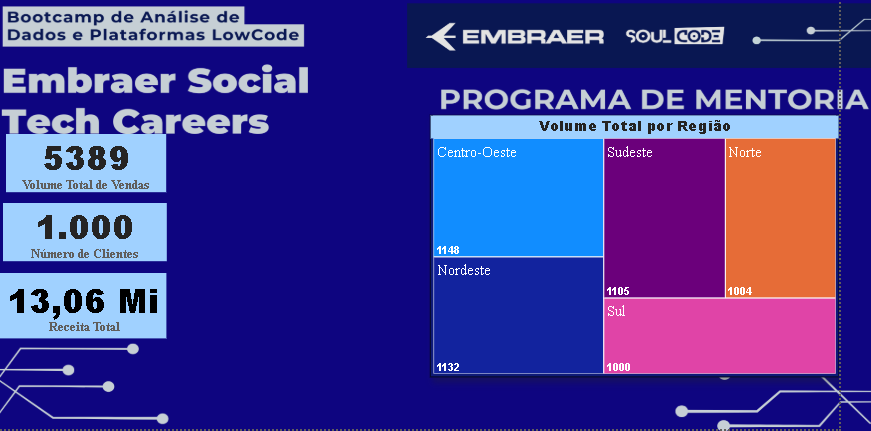


### Categorias Mais Vendidas:

* App: Líder em volume de vendas, com um total de 2860 produtos.

* Assinatura: Teve 1518 produtos vendidos.

* Suporte: Com um volume total de 1011 produtos vendidos.



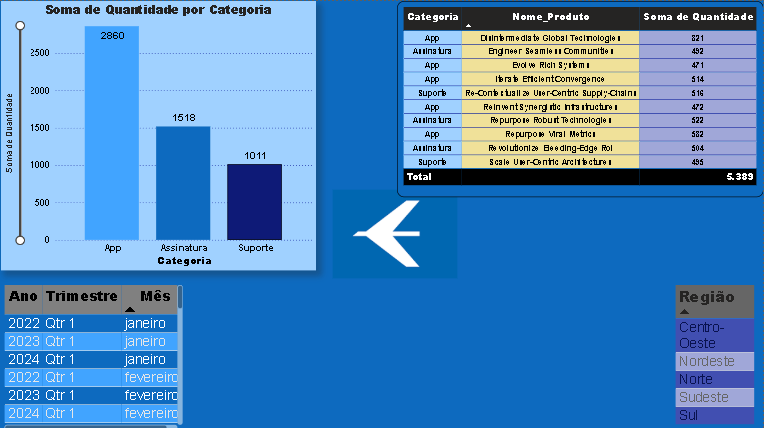

### Produtos Mais Vendidos:

* Disintermediate Global Technologies : 821 unidades.

* Repurpose Viral Metrics : 582 unidades.

* Repurpose Robust Technologies: 522 unidades.

* Re-Contextualize User-Centric Supply-Chains : 516 unidades

### Regiões de Vendas:

* Sudeste foi a região que obteve maior número de vendas.
* Nordeste : foi a segunda com maior número de vendas


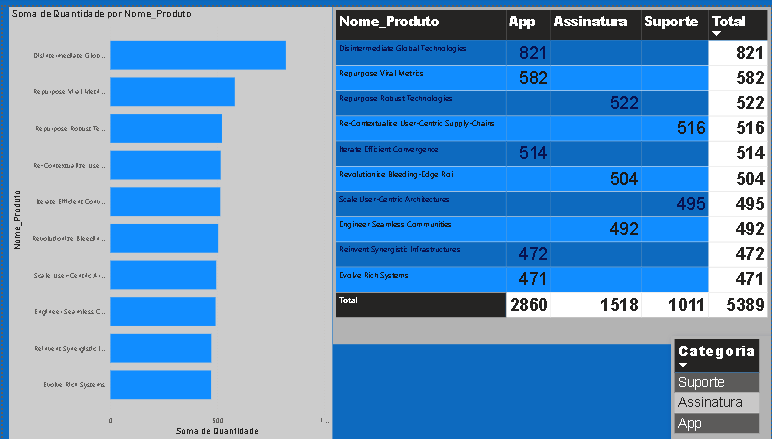


### Receita por Setor:

* Saúde lidera em receita total (22,74%).
* Manufatura representa a segunda maior fatia (21,33%)

### Educação também é bastante relevante (19,6%).

  * Desempenho Individual de Vendedores: Apresentado por um gráfico em barras horizontais e que evidencia as melhores performance.



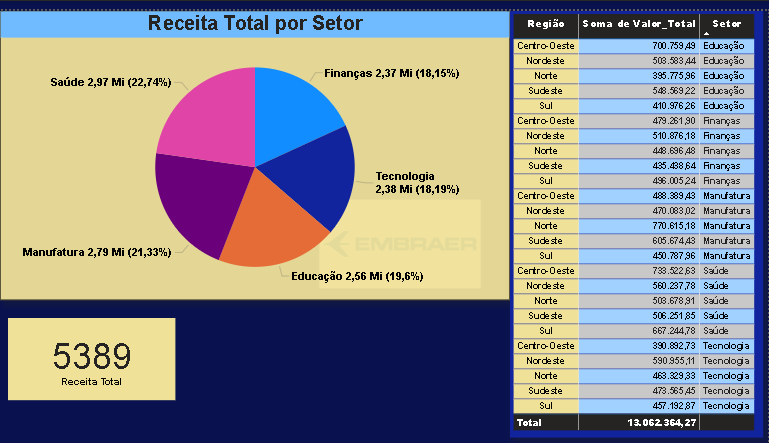

### Resultados da Análise

* A análise revelou:

Pontos Fortes: Produtos e categorias com alta performance de vendas.

Pontos Fracos: Produtos e regiões com desempenho abaixo da média.

* Impactos Práticos

Os principais impactos e recomendações da análise incluem:

  * Investimento: Destinar mais investimento aos produtos mais populares para crescimento da empresa.

  * Treinamentos: Implementar treinamento de vendas aos vendedores e reavaliação de estrutura.

  * Reavaliação: Rever produtos com pouca procura e rever categorias menos vendidas.

  * Marketing: Aumentar o investimento em marketing e focar no aprimoramento dos vendedores em áreas com baixo desempenho.

### Tecnologias Utilizadas

O projeto utilizou várias ferramentas como Google Colab, MySQL, BigQuery, Google Cloud Storage, Google Cloud e Power BI.

* Arquivos

O trabalho da análise de dados ficou registrado em arquivo .ipynb (para o Google Colab) e em .pbix para o Power Bi

Analise Power BI

* https://drive.google.com/file/d/1sYMjoCe7KiRLz_ca98NbSBoW4wAuFKKB/view?usp=sharing

* https://drive.google.com/file/d/1JQggJ9RabiSaQ0iXPrsDsFHmCZw6WLDi/view?usp=sharing

Apresentação

* https://docs.google.com/presentation/d/14RkXkt8VWqSDXroFncDUAW01Rjb3BELwCGyJsaPHMk4/edit#slide=id.p